In [1]:
import flowsolve as FS
import thermosolve as TS
import mesh as m
import numpy as np
import os, gc
import pickle as pkl

In [6]:
path = './room_with_view_open_slow/'
files = os.listdir(path)
files.sort()

In [7]:
files = [f for f in files if not f.startswith('anim')]

In [8]:
#files.pop(0)
files[0]

'datadump.bin'

In [9]:
with open(path+files.pop(0), 'rb') as f:
    stuff = pkl.load(f)

In [10]:
stuff

 array([1.00000000e+01, 7.57465828e+00, 4.54885812e+00, ...,
        1.57633803e-12, 2.84285475e-12, 3.95661043e-12]),
 array([0.        , 0.        , 0.        , ..., 0.00244879, 0.00117235,
        0.0030165 ])]

In [11]:
tmesh = stuff[1]

In [12]:
fmesh = stuff[0]

In [13]:
with open(path+files[-1], 'rb') as f:
        uconv, tconv, t, dtconv = pkl.load(f)

In [14]:
Lt = stuff[3]
Lf = stuff[2]

In [15]:
abs(uconv[:fmesh.nnodesP2*2]).max()

1.8648709555072438

In [16]:
abs(tconv[:tmesh.nnodesP2]).max()

30.1

In [17]:
scaling = ((fmesh.nodes[:,1].max()-fmesh.nodes[:,1].min())
                  /(fmesh.nodes[:,0].max()-fmesh.nodes[:,0].min()))#**0.25
dpi = 75
width = 3200/dpi
height = scaling*3200*1.33/dpi
height += height%2

In [18]:
def graphit(axes, ucoeffs, tsol, mesh, t, scale):
    nodes = mesh.nodes
    els = mesh.els
    tsol = mesh.map_solution_back(tsol)
    u_x = ucoeffs[:,0]
    u_y = ucoeffs[:,1]
    vol_els = [a[1:4] for a  in mesh.els if a[0]==6 ]
    tris = mtri.Triangulation(nodes[:,0],nodes[:,1],np.vstack(vol_els))
    

    
    if type(scale) is float:
        v = np.linspace(-scale, scale   ,100)
    else: # give scale as (min,max)
        v = np.linspace(scale[0], scale[1]   ,100)
    
    ysss = axes.tricontourf(tris, tsol, v, cmap='bwr')
    
    axes.set_aspect('equal')
    
    axes.triplot(tris, color=(0.5,0.5,0.5,0.7))
    
    if t is None:
        axes.set_title('Temperature')
    else:
        axes.set_title('Temperature at t='+f"{t:2.03f} seconds. Max temperature:"  + f"{tsol.max():2.01f}"
                       , fontsize=40)
    
    # Plots direction of the electrical vector field
    sol_norm = np.sqrt((u_x**2+u_y**2))
    for i in range(sol_norm.shape[0]):
        if sol_norm[i] == 0. :
            sol_norm[i] = 1.
    
    axes.quiver(tris.x, tris.y, u_x/sol_norm, u_y/sol_norm,
              units='xy', scale=50., zorder=3, color=(0.75,0.75,0.75,0.75),
              width=0.007, headwidth=1., headlength=3.)

    return ysss
    
    

In [20]:
nodesofinterest = []
numnodes = 800
for i in range(numnodes):
    found = False
    while not found:
        node = np.random.randint(0,tmesh.nodes.shape[0])
        if node not in nodesofinterest and node not in fmesh.dirich_nodes:
            nodesofinterest.append(node)
            found = True

In [ ]:
#with open('nodesinterest.bin', 'wb') as f:
    pkl.dump(nodesofinterest, f)

In [ ]:
with open('nodesinterest.bin', 'rb') as f:
    nodesofinterest = pkl.load( f)

In [21]:
xnodes = [tmesh.nodes[node,0] for node in nodesofinterest]
ynodes = [tmesh.nodes[node,1] for node in nodesofinterest]

In [22]:
def graphflow(axes, ucoeffs,  mesh, t, scale):
    nodes = mesh.nodes
    els = mesh.els
    u_x = ucoeffs[:,0]
    u_y = ucoeffs[:,1]
    speed = np.sqrt((u_x**2+u_y**2))
    vol_els = [a[1:4] for a  in mesh.els if a[0]==6 ]
    tris = mtri.Triangulation(nodes[:,0],nodes[:,1],np.vstack(vol_els))
    

    
    if type(scale) is float:
        v = np.linspace(0, scale   ,100)
    else: # give scale as (min,max)
        v = np.linspace(scale[0], scale[1]   ,100)
    
    ysss = axes.tricontourf(tris, speed*Peclet*10, v)
    
    axes.set_aspect('equal')
    
    axes.triplot(tris, color=(0.5,0.5,0.5,0.7))
    
    if t is None:
        axes.set_title('Speed')
    else:
        axes.set_title('Peclet number at t='+f"{t:2.03f} seconds", fontsize=40)
    
    # Plots direction of the electrical vector field
    sol_norm = speed
    for i in range(sol_norm.shape[0]):
        if sol_norm[i] == 0. :
            sol_norm[i] = 1.
    
    axes.quiver(xnodes, ynodes, 
                [(u_x/sol_norm)[node] for node in nodesofinterest], 
                [(u_y/sol_norm)[node] for node in nodesofinterest],
              units='xy', scale=12., zorder=3, color=(0.75,0.75,0.75,0.75),
              width=0.07, headwidth=1., headlength=3.)

    return ysss
    
    

In [23]:
import numpy as np
from matplotlib import pyplot as plt

import matplotlib.tri as mtri

In [24]:
Peclet = 1/(.0262/1.3/1000*100.)

In [26]:
Peclet

49618.32061068702

In [27]:
def calc_avg_temp(tconv, tmesh):
    inttemp = 0.
    for el in range(tmesh.els.shape[0]):
        
        if tmesh.els[el,0]==6:
            node_coords = tmesh.get_element_node_coords(el)
            dofs = TS.np.zeros(6)
            for i in range(6):
                node = tmesh.els[el,i+1]
                dof_tn = tmesh.node_dof_lookup[node]
                dofs[i] = tconv[dof_tn]
            for i in range(tmesh.gauss_points.shape[0]):
                xi_eta = tmesh.gauss_points[i,:2]
                weight = tmesh.gauss_points[i,-1]
                det = TS.np.linalg.det(TS.P2FE.jacobian(xi_eta, node_coords))
                tval = TS.P2FE.shape_func_vec(xi_eta).dot(dofs)
                inttemp += tval*weight*det
    return inttemp
                

In [29]:
times = []
tconvnorm = []
tconvnormmass = []
kineticenergy = []
tmesh.determine_gauss_points(1)
for file in files[0::1]:
    with open(path+file, 'rb') as f:
        uconv, tconv, t, dt = pkl.load(f)
    times.append(t)
    tconvnorm.append(calc_avg_temp(tconv, tmesh)/24.2)
    
    #tconvnormmass.append(((tconv[:tmesh.nnodesP2].dot(Lt.mass.dot(tconv[:tmesh.nnodesP2])))/17.7)**.5)
    print(tconvnorm[-1])
    kineticenergy.append(np.dot(uconv[:fmesh.nnodesP2*2],
                                       Lf.mass.dot(uconv[:fmesh.nnodesP2*2]))/2*1.3)
    

7.7389919881734395
7.753886781821861
7.768192753788746
7.78213486590951
7.795863729532349
7.809486167502531
7.823080641311428
7.836704594555275
7.850397608181312
7.864183066541859
7.878069743569786
7.892053551722506
7.9061191951625815
7.920241496673482
7.934386069933732
7.9485084334602
7.962550027555651
7.976429635656864
7.990029740226865
8.003179181379092
8.01563590109527
8.027076232929716
8.03709898687824
8.045251161111985
8.051075585606384
8.054170785522984
8.054245935581665
8.05115505674631
8.044904269404253
8.03563690901686
8.023606690172196
8.009147804697708
7.992646562557603
7.97451576750084
7.955171788040262
7.935014526633195
7.914411020949099
7.893683539511005
7.873102669914632
7.852885266332802
7.833196498191796
7.814154821822774
7.795838568940425
7.778292988212215
7.761536886352435
7.745568365766986
7.730369455785756
7.715909658632207
7.702148599860631
7.6890381033521
7.67652408260934
7.664548604410544
7.653052307863442
7.6419770854768405
7.631268656504282
7.620878515867409


6.2006726149937865
6.2011692356168115
6.201702369015263
6.2022600011922195
6.202826081816445
6.20338088439802
6.203902019153551
6.204366210533782
6.204751855728841
6.205042202100241
6.2052287213172725
6.205313975184181
6.205313099427958
6.20525313457061
6.20516985921272
6.205102397683825
6.205086437037878
6.205147220776731
6.205293600730331
6.2055144508084625
6.205778653180795
6.206039345972909
6.206241953336725
6.206334158218788
6.206275320089581
6.20604319063537
6.205636581479784
6.205073468388305
6.204385099201327
6.203607955350558
6.202776063228507
6.201915612677649
6.201042675826218
6.200163875514848
6.199279286003231
6.198386447226214
6.19748421044656
6.196575404629064
6.195667898617596
6.194774187328588
6.193909942601709
6.193092057761111
6.192336665781645
6.1916574844796495
6.191064686704318
6.190564356707061
6.190158500419649
6.189845520975714
6.189621035008871
6.1894788837023755
6.189412188871154
6.189414320592629
6.1894796733651685
6.1896041823611085
6.189785542227727
6.1900

6.177587670415078
6.176713268974832
6.175845815164527
6.175001311227619
6.174197487193701
6.173451810071306
6.172779788452933
6.172193779521877
6.171702337198326
6.171310044963422
6.171017745959297
6.170823079558514
6.170721230779897
6.170705793619076
6.170769650282951
6.170905779993875
6.171107929271194
6.171371093061886
6.171691768911084
6.172067956141325
6.172498883718192
6.172984469140283
6.17352453874667
6.174117875656514
6.174761199260704
6.17544821152281
6.176168863302858
6.176908995794765
6.177650499275135
6.178372105127011
6.179050884456154
6.1796644571139145
6.180193800719734
6.180626373810927
6.180959042282796
6.1812000981429165
6.181369615877903
6.18149761317946
6.181619951994206
6.1817724718789995
6.181984292119876
6.182271458819549
6.182632202215232
6.183045063473323
6.183470886558108
6.183858850479667
6.184155418691789
6.184314016672334
6.184303090089793
6.184110798330517
6.183745395474537
6.183231279793734
6.182601934284877
6.181892034254048
6.1811310256407355
6.1803395

In [ ]:
#kineticenergy = [k/5 for k in kineticenergy]

In [33]:
np.array(kineticenergy).min()

1.2552391865851058

In [ ]:
with open(path+'zgraph.bin', 'wb') as f:
    pkl.dump([times, tconvnorm, kineticenergy], f)

In [ ]:
with open(path+'zgraph.bin', 'rb') as f:
    times, tconvnorm=pkl.load( f)

<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0806.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0807.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0808.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0809.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0810.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0811.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0812.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0813.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0814.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0815.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0816.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0817.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0818.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0819.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0820.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0821.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0822.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0823.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0824.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0825.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0826.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0827.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0828.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0829.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0830.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0831.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0832.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0833.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0834.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0835.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0836.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0837.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0838.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0839.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0840.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0841.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0842.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0843.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0844.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0845.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0846.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0847.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0848.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0849.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0850.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0851.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0852.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0853.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0854.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0855.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0856.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0857.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0858.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0859.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0860.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0861.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0862.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0863.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0864.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0865.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0866.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0867.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0868.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0869.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0870.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0871.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0872.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0873.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0874.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0875.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0876.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0877.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0878.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0879.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0880.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0881.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0882.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0883.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0884.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0885.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0886.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0887.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0888.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0889.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0890.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0891.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0892.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0893.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0894.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0895.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0896.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0897.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0898.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0899.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0900.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0901.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0902.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0903.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0904.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0905.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0906.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0907.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0908.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0909.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0910.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0911.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0912.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0913.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0914.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0915.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0916.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0917.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0918.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0919.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0920.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0921.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0922.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0923.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0924.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0925.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0926.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0927.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0928.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0929.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0930.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0931.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0932.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0933.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0934.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0935.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0936.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0937.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0938.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0939.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0940.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0941.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0942.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0943.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0944.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0945.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0946.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0947.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0948.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0949.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0950.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0951.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0952.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0953.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0954.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0955.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0956.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0957.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0958.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0959.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0960.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0961.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0962.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0963.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0964.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0965.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0966.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0967.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0968.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0969.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0970.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0971.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0972.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0973.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0974.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0975.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0976.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0977.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0978.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0979.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0980.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0981.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0982.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0983.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0984.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0985.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0986.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0987.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0988.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0989.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0990.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0991.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0992.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0993.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0994.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0995.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0996.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0997.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0998.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-0999.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1000.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1001.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1002.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1003.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1004.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1005.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1006.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1007.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1008.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1009.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1010.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1011.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1012.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1013.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1014.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1015.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1016.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1017.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1018.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1019.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1020.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1021.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1022.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1023.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1024.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1025.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1026.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1027.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1028.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1029.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1030.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1031.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1032.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1033.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1034.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1035.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1036.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1037.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1038.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1039.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1040.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1041.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1042.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1043.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1044.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1045.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1046.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1047.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1048.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1049.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1050.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1051.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1052.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1053.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1054.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1055.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1056.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1057.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1058.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1059.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1060.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1061.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1062.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1063.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1064.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1065.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1066.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1067.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1068.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1069.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


results-1070.bin  done.


<ipython-input-39-62a6860413aa>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


KeyboardInterrupt: 

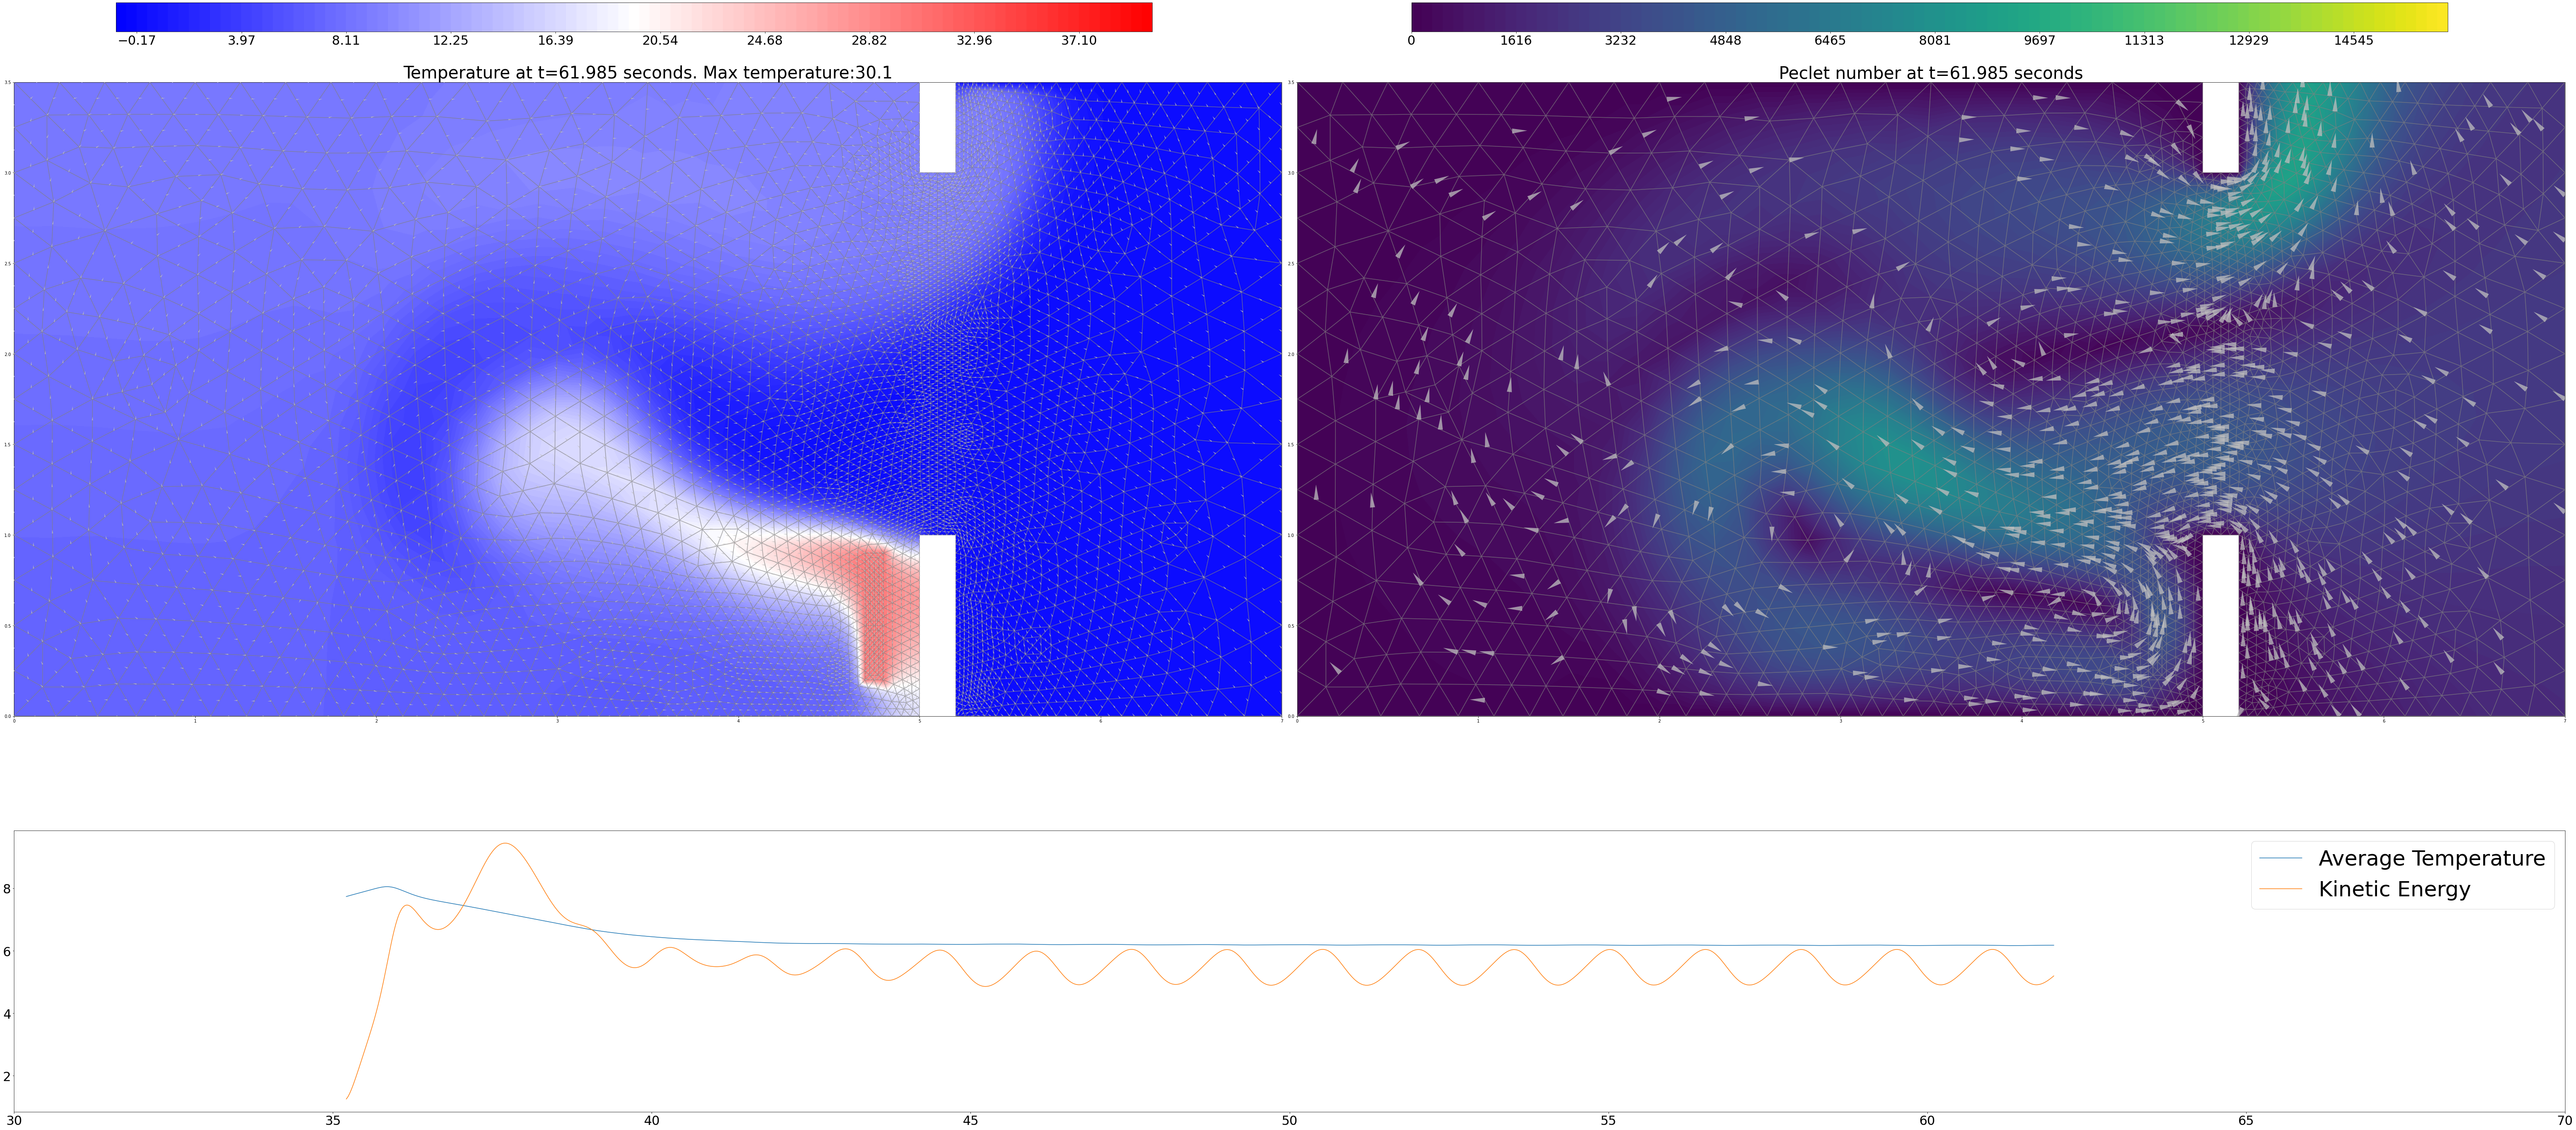

In [39]:

Lt = stuff[3]
i = 806
for file in files[i*1::1]:
    with open(path+file, 'rb') as f:
        uconv, tconv, t, dt = pkl.load(f)
    fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(width*2,height*1.333))
    gs = axs[3, 3].get_gridspec()
    # remove the underlying axes
    for ax in axs[0:,0:].ravel():
        ax.remove()
    
    axbig = fig.add_subplot(gs[3, 0:])
    axbig.set_xlim(left=30., right=70.)
    left = fig.add_subplot(gs[0:3, 0:2])
    right = fig.add_subplot(gs[0:3,2:])
    temp = graphit(left, fmesh.map_solution_back(uconv), tconv, tmesh, t, (-1,40.))
    flow = graphflow(right, fmesh.map_solution_back(uconv), tmesh, t, 16000.)
    cbaxes = fig.add_axes([0.05, 0.945, 0.4, 0.025]) 
    cbaxes2 = fig.add_axes([0.55, 0.945, 0.4, 0.025]) 
    fig.colorbar(temp, orientation='horizontal', cax=cbaxes)
    fig.colorbar(flow, orientation='horizontal', cax=cbaxes2)
    for label in cbaxes.xaxis.get_ticklabels():
        label.set_fontsize(30)
    for label in cbaxes2.xaxis.get_ticklabels():
        label.set_fontsize(30)
    axbig.xaxis.set_tick_params(labelsize=30)
    axbig.yaxis.set_tick_params(labelsize=30)
    fig.tight_layout()
    axbig.plot(times[:i+1],tconvnorm[:i+1], label='Average Temperature')
    axbig.plot(times[:i+1],kineticenergy[:i+1],  label='Kinetic Energy ')
    axbig.legend(fontsize=50)
    fig.savefig(path+'anim-'+f"{i:04d}"+'.png')
    i+=1
    print(file, " done.")
    plt.draw()
    fig.clf()
    plt.close(fig)
    plt.close('all')
    if i%50==0:
        gc.collect()

In [40]:
gc.collect()

38446

In [ ]:
i

In [ ]:
files[i*4]

In [ ]:
np.linalg.norm(Lt.forcing*tconv[:tmesh.nnodesP2])

In [ ]:
files[1472]

In [ ]:
((tconv[:tmesh.nnodesP2].dot(Lt.mass.dot(tconv[:tmesh.nnodesP2])))/17.7)**.5

In [ ]:
Lt.calc_area()


In [ ]:
tconv[:tmesh.nnodesP2].max()

In [ ]:
uconv[:fmesh.nnodesP2*2].min()**2#*5000

In [ ]:
1/(Lf.mu*100/Lf.rho)

In [ ]:
Reynolds = 650


In [ ]:
Peclet*10

In [ ]:
uconv[:fmesh.nnodesP2*2].dot(Lf.mass.dot(uconv[:fmesh.nnodesP2*2]))/2*10